# Loading Datasets

In [3]:
from datasets import load_dataset

In [4]:
dataset1 = load_dataset("billsum")

In [5]:
dataset2 = load_dataset('cnn_dailymail', '1.0.0')

In [6]:
dataset3 = load_dataset("sentence-transformers/wikihow")

In [7]:
print("First dataset (Billsum) loaded:")
print("Columns in the dataset:", dataset1["test"].column_names)
print("Number of examples in test set:", len(dataset1["test"]))
print(f"Test set size: {len(dataset1['test'])}")

print("First example in test set:")
print(dataset1["test"][0]["text"][:500] + "...") # Print first 500 characters of the first example

dataset1_test = dataset1["test"][0]["text"]

First dataset (Billsum) loaded:
Columns in the dataset: ['text', 'summary', 'title']
Number of examples in test set: 3269
Test set size: 3269
First example in test set:
SECTION 1. ENVIRONMENTAL INFRASTRUCTURE.

    (a) Jackson County, Mississippi.--Section 219 of the Water 
Resources Development Act of 1992 (106 Stat. 4835; 110 Stat. 3757) is 
amended--
        (1) in subsection (c), by striking paragraph (5) and inserting 
    the following:
        ``(5) Jackson county, mississippi.--Provision of an alternative 
    water supply and a project for the elimination or control of 
    combined sewer overflows for Jackson County, Mississippi.''; and
        (2) in...


In [8]:
print("Second dataset (CNN News) loaded:")
print("Columns in the dataset:")
print(dataset2["test"].column_names)
print("Number of examples in test set:", len(dataset2["test"]))

print("First example in test set:")
print(dataset2["test"][0]["article"][:500] + "...") # Print first 500 characters of the first example

dataset2_test = dataset2["test"][0]["article"]

Second dataset (CNN News) loaded:
Columns in the dataset:
['article', 'highlights', 'id']
Number of examples in test set: 11490
First example in test set:
(CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, includin...


In [9]:
print("Third dataset (Wiki) loaded:")
print("Columns in the dataset:", dataset3["train"].column_names)
print("Number of examples in train set:", len(dataset3["train"]))
print("First example in train set:")
print(dataset3["train"][0]["text"][:500] + "...") # Print first 500 characters of the first example

dataset3_test = dataset3["train"][0]["text"]

Third dataset (Wiki) loaded:
Columns in the dataset: ['text', 'summary']
Number of examples in train set: 128543
First example in train set:
So you're a new or aspiring artist and your creativity has spawned something  unique  and interesting. Now you're ready to display and sell this creation and perhaps make some money, but you're venturing into the unknown....


# Testing

We decided to evaluate our custom text summarization method, to do evaluation, we develop our **own ROUGE-1, ROUGE-2, and ROUGE-L metrics** to assess summarization quality. The evaluation **compares generated summaries (with a library Sumy) against reference summaries** with both numerical scores and visualizations.

In this section, we load source documents (which are billsum/news/wiki from previous cells) and reference summaries for testing our summarization system.

In [10]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer

from text_summarizer import run_text_summarization

def both_summarizers(dataset, number_of_sentences):
    parser = PlaintextParser.from_string(dataset, Tokenizer("english"))

    summarizer = LsaSummarizer()
    summary_lib = summarizer(parser.document, sentences_count=number_of_sentences)

    summary_lib = '\n'.join(str(sentence) for sentence in summary_lib)
    summary_implemented = run_text_summarization(dataset, number_of_sentences)
    
    return summary_lib, summary_implemented

### ROUGE (Recall-Oriented Understudy for Gisting Evaluation)

We use 3 ROUGE approaches (metrics)

**ROUGE 1**:
- Measures basic content coverage

*Answers a question -> Did our summary capture the important words?*

**ROUGE 2**:
- captures fluency/coherence.

*Answers a question -> Did our summary preserve meaningful phrases?*

---

$\text{Precision} = \frac{\text{Number of overlapping unigrams}}{\text{Total unigrams in generated summary}}$

$\text{Recall} = \frac{\text{Number of overlapping unigrams}}{\text{Total unigrams in reference summary}}$

$\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$

In [11]:
import re
from collections import Counter

def tokenize(text):
    return re.findall(r'\w+', text.lower())

def rouge_n(reference, generated, n=1):
    ref_tokens = tokenize(reference)
    gen_tokens = tokenize(generated)

    ref_ngrams = [tuple(ref_tokens[i:i+n]) for i in range(len(ref_tokens)-n+1)]
    gen_ngrams = [tuple(gen_tokens[i:i+n]) for i in range(len(gen_tokens)-n+1)]

    ref_counts = Counter(ref_ngrams)
    gen_counts = Counter(gen_ngrams)

    overlap = sum((ref_counts & gen_counts).values())

    precision = overlap / len(gen_ngrams) if gen_ngrams else 0
    recall = overlap / len(ref_ngrams) if ref_ngrams else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return {"precision": precision, "recall": recall, "f1": f1}

**ROUGE-L (Longest Common Subsequence)**:
- Evaluates sequence similarity.

*Answers a question -> Did our summary maintain the logical flow/order?*

- Compute:

$\text{Recall} = \frac{\text{LCS Length}}{\text{Length of reference}}$

$\text{Precision} = \frac{\text{LCS Length}}{\text{Length of generated}}$

$\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$

In [12]:
def lcs(X, Y):
    m, n = len(X), len(Y)
    dp = [[0] * (n+1) for _ in range(m+1)]
    for i in range(m):
        for j in range(n):
            if X[i] == Y[j]:
                dp[i+1][j+1] = dp[i][j] + 1
            else:
                dp[i+1][j+1] = max(dp[i+1][j], dp[i][j+1])
    return dp[m][n]

def rouge_l(reference, generated):
    ref_tokens = tokenize(reference)
    gen_tokens = tokenize(generated)

    lcs_len = lcs(ref_tokens, gen_tokens)

    recall = lcs_len / len(ref_tokens) if ref_tokens else 0
    precision = lcs_len / len(gen_tokens) if gen_tokens else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return {"precision": precision, "recall": recall, "f1": f1}

### Start analyzing

In [27]:
import matplotlib.pyplot as plt

results_for_dataset1 = []
results_for_dataset2 = []
results_for_dataset3 = []

n_list = [1, 2, 5, 15, 30, 50, 100, 125, 150, 200, 300]
for n in n_list:
    for i, dataset in enumerate([dataset1_test, dataset2_test, dataset3_test]):
        summary_lib, summary_implemented = both_summarizers(dataset, n)
        
        rouge1 = rouge_n(dataset, summary_lib, n=1)
        rouge2 = rouge_n(dataset, summary_lib, n=2)
        rougel = rouge_l(dataset, summary_lib)

        if i == 0:
            results_for_dataset1.append({
                'rouge1': rouge1,
                'rouge2': rouge2,
                'rougeL': rougel,
                'number_of_sentences': n
            })
        elif i == 1:
            results_for_dataset2.append({
                'rouge1': rouge1,
                'rouge2': rouge2,
                'rougeL': rougel,
                'number_of_sentences': n
            })
        else:
            results_for_dataset3.append({
                'rouge1': rouge1,
                'rouge2': rouge2,
                'rougeL': rougel,
                'number_of_sentences': n
            })

print("Results for Dataset 1 (Billsum): ", results_for_dataset1)
print("Results for Dataset 2 (CNN Dailymail): ", results_for_dataset2)
print("Results for Dataset 3 (Wiki): ", results_for_dataset3)

Results for Dataset 1 (Billsum):  [{'rouge1': {'precision': 1.0, 'recall': 0.025565388397246803, 'f1': 0.049856184084372}, 'rouge2': {'precision': 1.0, 'recall': 0.024606299212598427, 'f1': 0.04803073967339098}, 'rougeL': {'precision': 1.0, 'recall': 0.025565388397246803, 'f1': 0.049856184084372}, 'number_of_sentences': 1}, {'rouge1': {'precision': 1.0, 'recall': 0.05014749262536873, 'f1': 0.0955056179775281}, 'rouge2': {'precision': 1.0, 'recall': 0.04921259842519685, 'f1': 0.09380863039399626}, 'rougeL': {'precision': 1.0, 'recall': 0.05014749262536873, 'f1': 0.0955056179775281}, 'number_of_sentences': 2}, {'rouge1': {'precision': 1.0, 'recall': 0.19862340216322516, 'f1': 0.33141919606234616}, 'rouge2': {'precision': 0.9850746268656716, 'recall': 0.19488188976377951, 'f1': 0.3253903040262942}, 'rougeL': {'precision': 1.0, 'recall': 0.19862340216322516, 'f1': 0.33141919606234616}, 'number_of_sentences': 5}, {'rouge1': {'precision': 1.0, 'recall': 0.48672566371681414, 'f1': 0.654761904

In [31]:
import matplotlib.pyplot as plt

def plot_rouge_f1_scores(dataset_scores, dataset_name):
    sentence_counts = [entry['number_of_sentences'] for entry in dataset_scores]
    rouge1_f1 = [entry['rouge1']['f1'] for entry in dataset_scores]
    rouge2_f1 = [entry['rouge2']['f1'] for entry in dataset_scores]
    rougel_f1 = [entry['rougeL']['f1'] for entry in dataset_scores]

    plt.figure(figsize=(12, 6))
    plt.plot(sentence_counts, rouge1_f1, marker='o', label='ROUGE-1 F1')
    plt.plot(sentence_counts, rouge2_f1, marker='s', label='ROUGE-2 F1')
    plt.plot(sentence_counts, rougel_f1, marker='^', label='ROUGE-L F1')

    plt.title(f"ROUGE F1 Scores vs Number of Sentences ({dataset_name})")
    plt.xlabel("Number of Sentences in Summary")
    plt.ylabel("F1 Score")
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend()
    plt.show()

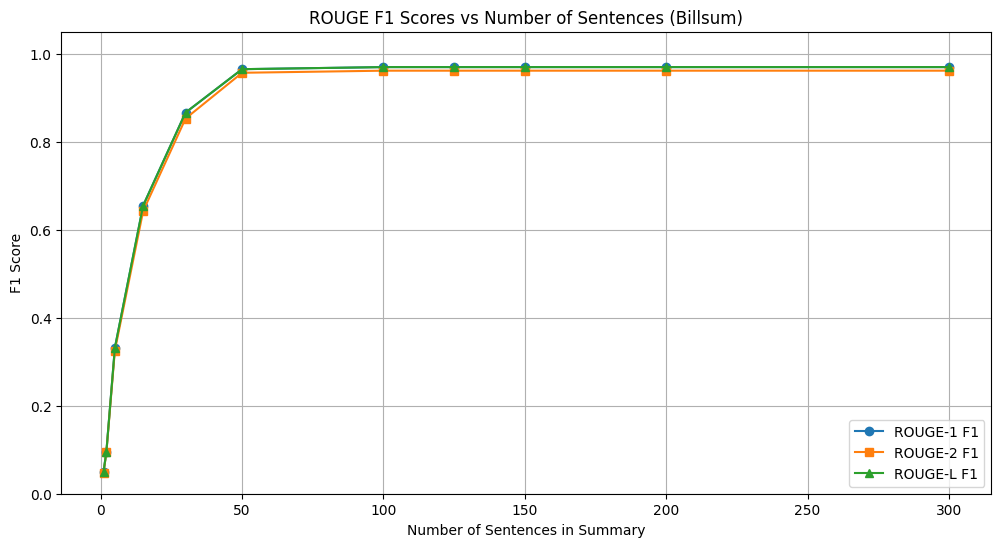

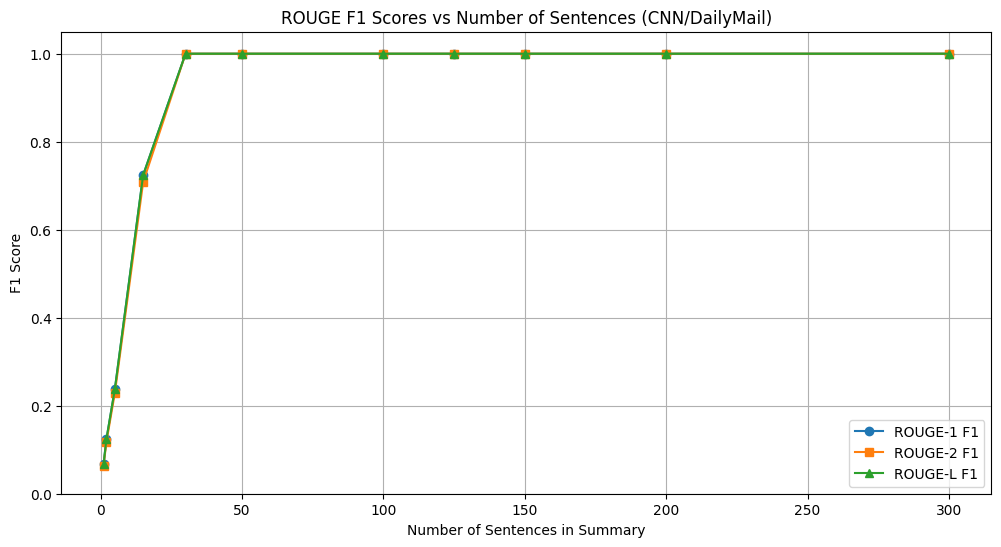

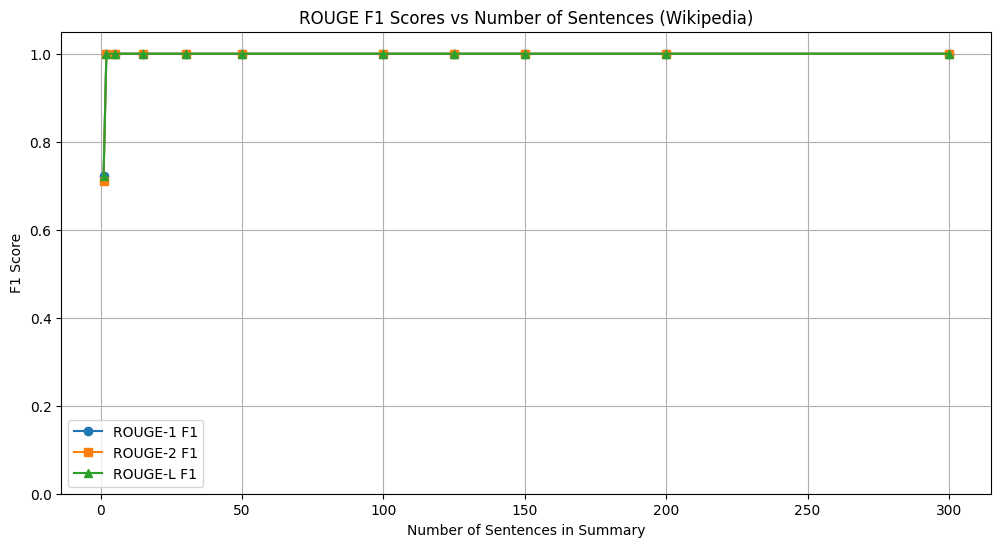

In [30]:
plot_rouge_f1_scores(results_for_dataset1, "Billsum")
plot_rouge_f1_scores(results_for_dataset2, "CNN/DailyMail")
plot_rouge_f1_scores(results_for_dataset3, "Wikipedia")

**Billsum Dataset Analysis**

The Billsum dataset exhibits a more gradual growth in ROUGE F1 scores compared to CNN/DailyMail. Starting from low F1 scores with minimal sentences, the curve steadily rises, reaching near-optimal performance around 50 sentences. The scores continue to improve slightly before stabilizing close to 1.0, indicating that this dataset requires a more extensive summary to achieve full coverage. This trend highlights that Billsum contains more dispersed key information across a larger number of sentences, and the summarizer effectively accumulates relevant content as the summary length increases.

**CNN/DailyMail Dataset Analysis**

In the CNN/DailyMail dataset, the ROUGE F1 scores demonstrate a sharp increase as the number of sentences in the summary grows. Initially, with very few sentences, the F1 scores are low, indicating limited content coverage. However, around 30 sentences, all ROUGE metrics (ROUGE-1, ROUGE-2, ROUGE-L) reach a perfect score of 1.0, suggesting that the summarizer fully captures the reference content at this point. Beyond this threshold, the scores plateau, showing that adding more sentences does not contribute additional value. This behavior reflects a moderately dense dataset where a relatively short summary (~30 sentences) is sufficient to cover all critical information effectively.

**Wikipedia Dataset Analysis**

For the Wikipedia dataset, the ROUGE F1 scores are exceptionally high from the outset. With just 2 sentences, the summarizer achieves perfect scores across all ROUGE metrics, which then remain constant regardless of further sentence additions. This indicates that Wikipedia summaries are highly concentrated, with essential information captured almost immediately. The flat curve beyond 2 sentences suggests that the summarizer retrieves all necessary content very efficiently, reflecting the concise and well-structured nature of Wikipedia articles where critical information is typically front-loaded.